In [1]:
import TreeWorld
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.animation as animation
from matplotlib.colors import LogNorm, Normalize
from scipy import stats
import figures 
import gridworld_utils as util
from importlib import reload
import time
reload(util)
reload(figures)
reload(TreeWorld)


<module 'TreeWorld' from '/home/rafal/UGPOP/projectsUGPOP/collaborative-intelligence/TreeWorld.py'>

We are going to walk through a multi-agent foraging model. This is sandbox for specifying a family of multi-agent foraging problems. I will show you what parameters you can tune and what the resulting behavior looks like. 

#Part 1: Environment

The basic setup is a discrete 2-dimensional grid world with dimensions `edge_size` $\times$ `edge_size`. It is an open environment with no obstacles. The minimal constraints in this environment are the spatiotemporal statistics of food rewards. In this section we will visualize and play with different parameters that control these spatiotemporal statistics.

Let's start with spatial statistics. It is assumed that food comes in square patches of dimension `patch_dim` $\times$ `patch_dim`. The main variables that we can tune are:

* `N_food_units_total`: the total number of food units in the environment 
* `patch_dim`: dimension of a single square food patch. Given a fixed value for `N_food_units_total`, the `patch_dim` parameter effectively controls how clustered and distributed the patches of food are. 
Play around with these two parameters. 

<Axes: title={'center': 'Environment with food patches'}>

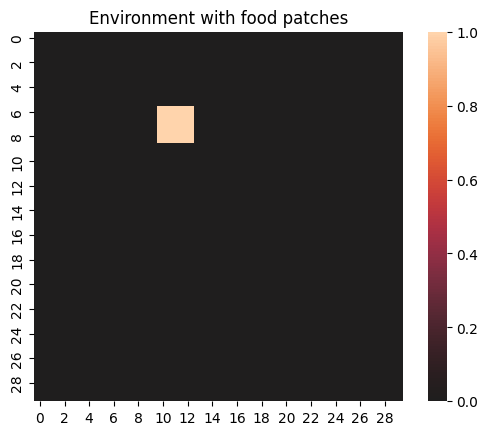

In [5]:
env1 = TreeWorld.Environment(edge_size=30, N_total_food_units=1, patch_dim=3)

# Add food 
env1.add_food_patches(food_statistics_type="drop_food_once")

fig, ax = plt.subplots()
ax.set_title('Environment with food patches')
sns.heatmap(ax=ax, data=np.reshape(env1.phi_food, (env1.edge_size, env1.edge_size)), center=0, square=True, cbar=True)


Now let's consider temporal statistics. We're going to assume food rewards appear with Poisson statistics.aZ We will specify a rate of appearance. 
* PARAMETER: 

****** CURRENTLY FOOD JUST DECAYS *****

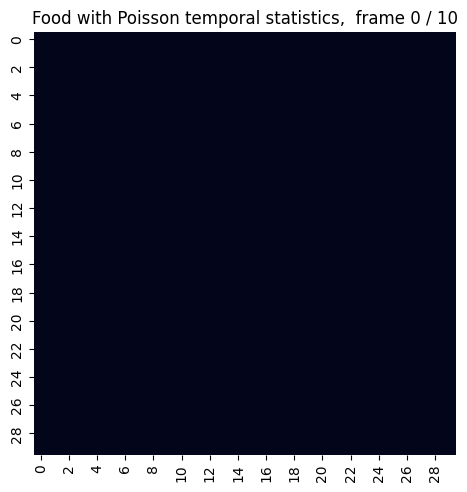

In [6]:
reload(TreeWorld)
%matplotlib notebook
%matplotlib inline
from IPython.display import HTML

plt.close('all')

# Create an initialize a new enviornment 
env = TreeWorld.Environment(edge_size=30, N_total_food_units=16, patch_dim=1, max_step_size=3)

# Add food 
food_statistics_type = "drop_food_once"
env.add_food_patches(food_statistics_type=food_statistics_type)

N_timesteps = 10
food_trajectory = np.zeros([env.N_states, N_timesteps]) # track food calories over time 

for ti in range(N_timesteps - 1):
    # update environment
    env.food_calories_by_loc -= env.food_decay_rate * env.food_calories_by_loc # food decay
    food_trajectory[:, ti + 1] = env.food_calories_by_loc.flatten()    # (N_states, N_timesteps)    

# *********** ANIMATION **********

fig, ax = plt.subplots()
min_cal = np.min(food_trajectory)
max_cal = np.max(food_trajectory)
sns.heatmap(ax=ax, data=np.reshape(food_trajectory[:, 0], [env.edge_size, env.edge_size]) , vmin=min_cal, vmax=max_cal, square=True, cbar=False) 
fig.tight_layout()

def update_plot(frame, food_trajectory, env): #, list_food_loc_id, edge_size):
    ax.set_title('Food with Poisson temporal statistics, ' + ' frame ' + str(frame) + ' / ' + str(N_timesteps))
    food_heatmap = np.reshape(food_trajectory[:, frame], [env.edge_size, env.edge_size]) 
    sns.heatmap(ax=ax, data=food_heatmap, vmin=min_cal, vmax=max_cal, square=True, cbar=False) #, cbar_ax=ax_cbar, cbar_kws={'shrink':0.5})
    return
    
anim_poisson_food = animation.FuncAnimation(fig, update_plot, frames=N_timesteps,
                                fargs=(food_trajectory, env)) #, list_food_loc_id, edge_size))

HTML(anim_poisson_food.to_html5_video())


Part 2: Anatomy of a bird agent 

Now that you've had a chance to play with the environment, let's add in the birds!
For this part, I will walk you through the internals of a bird agent step by step. A bird agent consists of the following: 
1) State - the agent's current location in the grid. 
2) World Model - a world model generates predictions of where the agent thinks there will be reward in the future. The main parts of the world model are the 
   
    * Transition matrix T 
    * Temporal discount factor gamma 
    * Successor Representation matrix M
  
In a few sections, I will explain what each of these variables are.   
1) Value function - this function is a mapping from state (i.e. location) to value. Applying this function to all locations results in a vector of values for each location. We will visualize this as a 2-dimensional heatmap of our grid world where the color represents the value at a given location. 
2) Policy - a function mapping from a state to action, specifically from the agent's current location to a next location. I have implemented both a deterministic and a probabilistic version of this policy. The deterministic policy is simply a greedy one - choose the location of maximum value. The probabilistic version uses a softmax function that takes as input an array of values corresponding to each eligible location and returns an array of probabilities for each eligible location. The policy then samples from the eligible locations according to those probabilities. 


In [53]:
# Intialize an environment with a bird agent

env = TreeWorld.Environment(edge_size=30, N_total_food_units=16, patch_dim=1)
env.add_food_patches(food_statistics_type="drop_food_once")

# agent_params 
# agent = TreeWorld.BirdAgent(env, agent_params, N_timesteps)
agent = TreeWorld.BirdAgent(env, N_timesteps, discount_factor=0.9, energy_init=50, sight_radius=10)


2.1 State  

The state of the world consists of the locations of all of the objects in the world, including food rewards and bird agents, as well as their caloric content. 

We can represent the bird's state as a one-hot vector with the length equal to the total number of locations in the environment. We will visualize the location in 2D. Let's assign the bird a random location: 

Text(0.5, 1.0, 'Agent state')

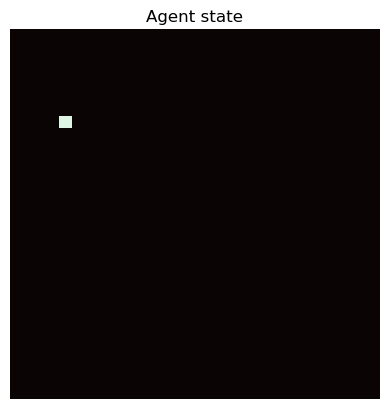

In [54]:
phi_agent = np.zeros([env.N_states, 1])
loc_1d = np.random.randint(env.N_states)
phi_agent[loc_1d] = 1
phi_agent_2d = np.reshape(phi_agent, (env.edge_size, env.edge_size))
fig, ax = plt.subplots()
sns.heatmap(ax=ax, data=phi_agent_2d, yticklabels=False, xticklabels=False, 
            square=True, vmin=0, vmax=1, cbar=False, cmap=sns.color_palette("mako", as_cmap=True))
ax.set_title('Agent state')

2.2 World Model 

A bird agent's world model consists of the following modules: 1) perception - extracting features from the state of the environment, 2) memory and prediction, 3) value - what the agent cares about, and 4) decision-making or action selection. An intuitive example of a perception-action loop is the following: a bird perceives food in the environment within a certain visibility range. Based on the locations of the food rewards and its current location in the environment, it predicts how valuable possible future locations are. It chooses where to move based on those predictions. Let's walk through each of these processes step by step.

2.2.1 Perception: radius of visibility around agent's current location vector
* vector indicating locations of food rewards $\phi_{food}$
* vector indicating which locations are visible to the agent $\phi_{visible}$ 
* The locations where food is visible are given by the indicator vector $\phi_{food} * \phi_{visible} $ 



Text(0.5, 1.0, 'visible food locations $\\phi_{food} * \\phi_{visible}$')

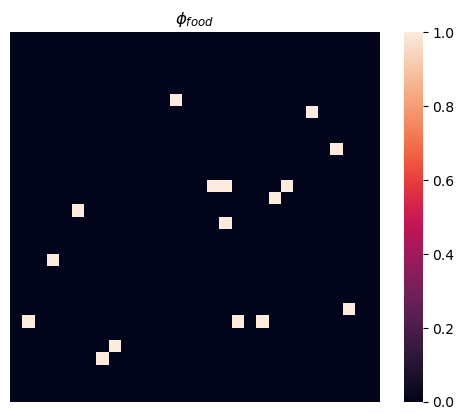

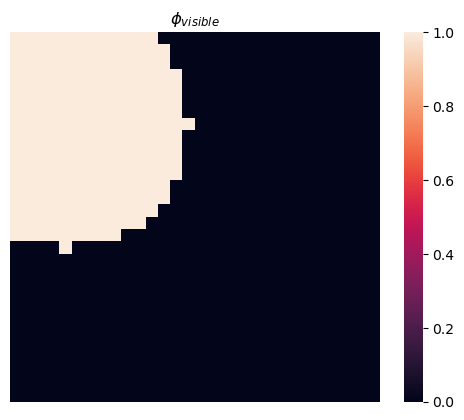

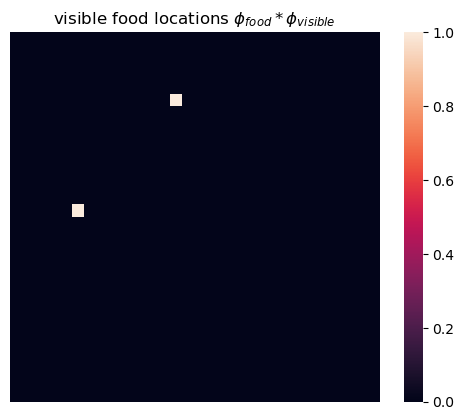

In [55]:

xloc_self, yloc_self = util.loc1Dto2D(loc_1d, env.edge_size)
phi_visible_2d = agent.compute_visible_locations(xloc_self, yloc_self, env)
phi_food_2d = np.reshape(env.phi_food, (env.edge_size, env.edge_size))
# w_food = env.phi_food * phi_visible_2d
w_food_2d =  phi_food_2d * phi_visible_2d

fig, ax = plt.subplots()
sns.heatmap(ax=ax, data=np.reshape(env.phi_food, (env.edge_size, env.edge_size)), yticklabels=False, xticklabels=False, 
            square=True, cbar=True, cmap=sns.color_palette("rocket", as_cmap=True))
ax.set_title('$\phi_{food}$')

fig, ax = plt.subplots()
sns.heatmap(ax=ax, data=phi_visible_2d, yticklabels=False, xticklabels=False, 
            square=True, cbar=True, cmap=sns.color_palette("rocket", as_cmap=True))
ax.set_title('$\phi_{visible}$')

fig, ax = plt.subplots()
sns.heatmap(ax=ax, data=w_food_2d, yticklabels=False, xticklabels=False, 
            square=True, cbar=True, cmap=sns.color_palette("rocket", as_cmap=True))
ax.set_title('visible food locations $\phi_{food} * \phi_{visible}$')


Next, we define a reward prediction vector $w_{food}$, which represents the agent's prediction of where there is food reward. For simplicity, we're going to use the visible food locations computed previously: 
* $w_{food} = \phi_{food} * \phi_{visible} $ 

These visible food locations will be the inputs to the memory and prediction module, which we will discuss next. 

2.2.2 Memory and prediction: Successor Representation Matrix $M$ 

We will now visualize how the agent generates predictive maps. The agent makes predictions based on the eligible state transitions given by the matrix $T$. The successor representation matrix is given by $M = (I - \gamma T)^-1$ where $\gamma$ is the temporal discount factor - a scalar between 0 and 1 representing how much the agent cares about the future. This is the infinite time horizon prediction - the agent is running the transition matrix forward in time many time steps. Let's start with the agent predicting where it can go in the future given its current location. : $M \phi_{agent}$.



Text(0.5, 1.0, 'Successor Representation applied to agent state')

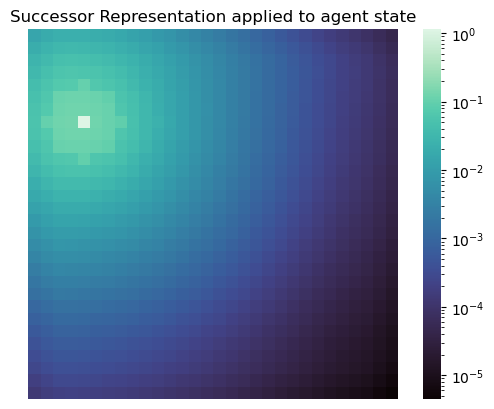

In [56]:
SR_phi = agent.SR @ phi_agent
SR_phi_2d = np.reshape(SR_phi, (env.edge_size, env.edge_size))
fig, ax = plt.subplots()
sns.heatmap(ax=ax, data=SR_phi_2d, yticklabels=False, xticklabels=False, 
            square=True, cbar=True, norm=LogNorm(), cmap=sns.color_palette("mako", as_cmap=True))
ax.set_title('Successor Representation applied to agent state')

The agent can use its sucessor representation to predict what locations will lead to a food reward by computing $w_{food}^T M $ over all the locations. 



Text(0.5, 1.0, 'Value of each location based on food reward locations')

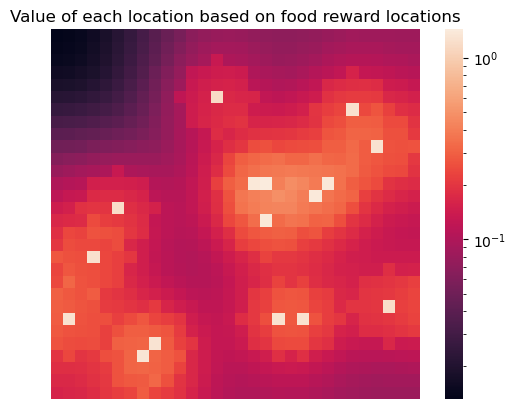

In [57]:
value_food = env.phi_food.T @ agent.SR
value_food_2d = np.reshape(value_food, (env.edge_size, env.edge_size))

vmin = np.min(value_food_2d)
vmax = np.max(value_food_2d)
if vmin <= 0: 
    vmin = 1e-5
if vmax <= 0:
    vmax = 1

fig, ax = plt.subplots()
sns.heatmap(ax=ax, data=value_food_2d, yticklabels=False, xticklabels=False, 
            square=True, cbar=True, norm=LogNorm(vmin=vmin, vmax=vmax), cmap=sns.color_palette("rocket", as_cmap=True))
            # square=True, vmin=0, vmax=1,  cbar=True,  cmap=sns.color_palette("rocket", as_cmap=True)
ax.set_title('Value of each location based on food reward locations')

We can repeat the perception and prediction processing for other sources of reward. For example, the agent might value the presence of other agents. 

2.3 Value Function 

As we saw before, the agent generates predictive maps for each reward type, where the agent predicts the magnitude of reward at a given location. We are now going to combine these reward prediction maps into a value function. The value function will simply be the weighted sum. Applied to all locations, we can visualize the output of the value function as a 2D heatmap. 

2.4 Policy Function 

#Part 3: Simulating different multi-agent behaviors

In the previous sections, we walked through different types of food statistics and the internals of a bird agent. Now we will put these pieces together and simulate multiple agents foraging in the same environment. The goal of this section is to understand how changing the value function of these agents changes their collective behavior. 

I'm going to show you a few types of agent "species" defined by their value function. The difference between each species is the weight they assign to different sources of reward: 
1) Ignorers - These agents only care about food. Reward increases with proximity to food. 
2) Avoiders - Assign negative reward to locations based on proximity to another bird. 
3) Followers - Assign positive reward to locations based on proximity to another bird.  
4) Communicators - Use information about food from other birds. They can see the food reward at locations occupied by other agents. 

We are going to assume XXX food statistics and focus on varying the internals of the value function.

3.1 Ignorers 

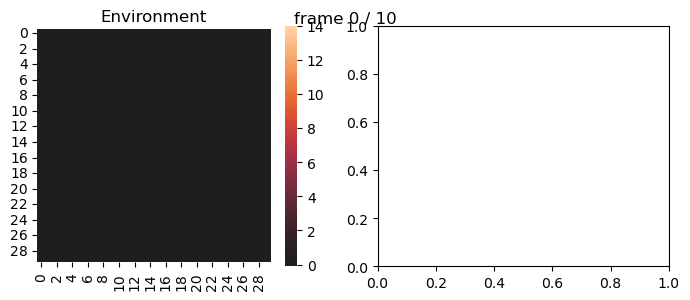

In [58]:
reload(TreeWorld)
%matplotlib notebook
%matplotlib inline
from IPython.display import HTML

# from matplotlib import rc 
# # equivalent to rcParams['animation.html'] = 'html5'
# rc('animation', html='html5')

# Set feature weights for the value function
c_food = 1
c_otheragents = 0
c_group = 0
c_weights = [c_food, c_otheragents, c_group]
# Set other parameters 
doShareFoodInfo = False
max_step_size = 3
sight_radius = 50
energy_init = 50
discount_factor = 0.9
caloric_cost_per_unit_dist = 1
doProbabilisticPolicy = True
doSoftmaxPolicy = True
exploration_bias = 0.001

# *** Functions ****
# initialize_environment(edge_size, patch_dim, N_food_units_total)
# 
# for each agent: 
#   initialize_agent(param_list)
#       T = build_transition_matrix(max_step_size, N_states)
# 
# for each time step t:
#   update_environment()
#   
#   for each agent:
#        agent.update_calories
#        compute features
#        select_action  



# Create an initialize a new enviornment 
env = TreeWorld.Environment(edge_size=30, N_total_food_units=16, patch_dim=1, max_step_size=3)

# Add food 
food_statistics_type = "drop_food_once"
env.add_food_patches(food_statistics_type=food_statistics_type)

# Add agents
list_agents = []

# Simulation parameters
N_timesteps = 10
food_trajectory = np.zeros([env.N_states, N_timesteps]) # track food calories over time 

for ti in range(N_timesteps - 1):

    env.food_calories_by_loc -= env.food_decay_rate * env.food_calories_by_loc
    food_trajectory[:, ti + 1] = env.food_calories_by_loc.flatten()    # (N_states, N_timesteps)   # save as a sparse matrix?

# *********** ANIMATION 
list_plot_agents = []
z = 0
min_value = 0
max_value = 1

fig_ui, (ax_main, ax_value) = plt.subplots(1, 2, figsize=(7, 3))
    
ax_main.set_title('Environment')
# phi_food_2d = np.reshape(phi_food, [edge_size,edge_size])
min_cal = -0.1
max_cal = np.max(food_trajectory)
food_init_loc_2d = np.reshape(food_trajectory[:, 0], [env.edge_size, env.edge_size])
sns.heatmap(ax=ax_main, data=food_init_loc_2d, vmin=min_cal, vmax=max_cal, center=0, square=True, cbar=True)

def update_plot(frame, food_trajectory, env): #, list_food_loc_id, edge_size):
    fig_ui.suptitle('frame ' + str(frame) + ' / ' + str(N_timesteps))
    # food locations and quantities
    food_heatmap = np.reshape(food_trajectory[:, frame], [env.edge_size, env.edge_size]) 
    sns.heatmap(ax=ax_main, data=food_heatmap, vmin=min_cal, vmax=max_cal, center=0, square=True, cbar=False) #, cbar_ax=ax_cbar, cbar_kws={'shrink':0.5})
    
    # x_food, y_food = util.loc1Dto2D(list_food_loc_id, edge_size)
    # plot_food.set_data(x_food, y_food)
    
    # # state of each agent 
    # for  ai, agent in enumerate(list_agents):
    #     state = int(agent.state_trajectory[frame])
    #     x, y = util.loc1Dto2D(state, env.edge_size)
    #     list_plot_agents[ai].set_data(x, y)
    
    # # value function of one agent 
    # ax_value.cla()
    # value_heatmap = np.reshape(list_agents[z].value_trajectory[:, frame], [env.edge_size, env.edge_size]) 
    # sns.heatmap(ax=ax_value, data=value_heatmap, vmin=min_value, vmax=max_value, center=0, square=True, cbar=False) #, cbar_ax=ax_cbar, cbar_kws={'shrink':0.5})
    
    return
    # return list_plot_agents #, plot_food
    
fig_ui.tight_layout()

ani = animation.FuncAnimation(fig_ui, update_plot, frames=N_timesteps,
                                fargs=(food_trajectory, env)) #, list_food_loc_id, edge_size))


HTML(ani.to_html5_video())


3.3 Followers

3.4 Communicators

Conclusion 

I hope that this tutorial has helped you understand how we can build a variety of multi-bird foraging systems.  
The long-term goal is to be able to do inference on this kind of model. The parameters in the value function are of most interest because they control what the agent cares about which ultimately influences their decisions. So the goal of inference would be to estimate the values of the weights for each factor in the value function. What makes this model unique is that the way we express the value function is 1) interpretable in terms of cognitive and neural mechanisms, and 2) has a statistical interpretation - inference of the feature weights amounts to Bayesian linear regression. For more details on the link between cognitive/neural and statistical descriptions, I encourage you to visit our manuscript (ask Emily or Marjorie for the pdf). 

Extensions and future directions
* This model can easily be extended by adding new features to the value function. We haven't considered predators yet.
* Energy constraints have yet to be incorporated into the value function. One of the key scientific questions Collaborative Intelligence is interested in asks, under what resource constraints and environmental constraints is social behavior advantageous? Birds in the real world have an internal representation of how costly certain situations will be...... [THINK MORE ABOUT HOW TO INCOPORATE THIS INTO THE MODEL]

Now let's define the transition function - what locations are eligible given the bird agent's current location. We will use a Euclidean distance rule, where all locations within a certain radius MAX_STEP_SIZE 

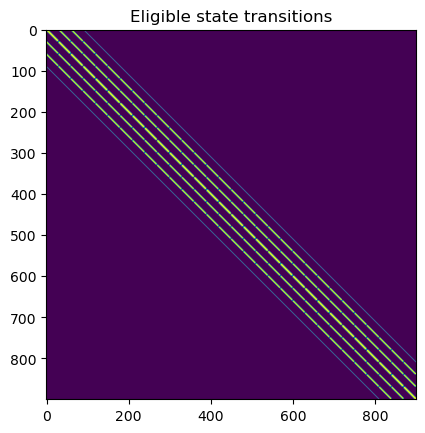

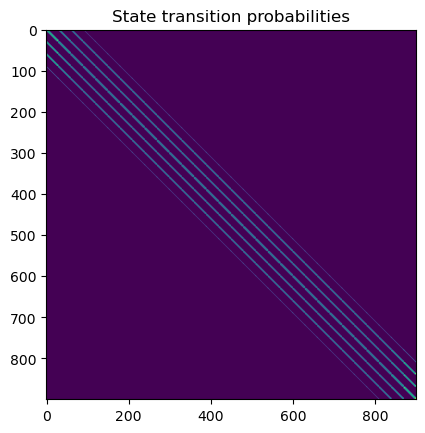

In [59]:

environment = TreeWorld.Environment()

plt.figure()
plt.title('Eligible state transitions')
plt.imshow(environment.T_eligible)

plt.figure()
plt.title('State transition probabilities')
plt.imshow(environment.T_prob)